## Confirming Interrupt Frequency Across 1 Millisecond Measurements

#### For every log file, isolating CPU-level metrics from NIC-level metrics results in a sparse matrix of zero-filled log entries amongst non-zero filled log entries that are about 1 millisecond apart.

In [84]:
import pandas as pd
import matplotlib.pyplot as plt
import eigen_analysis

In [7]:
cd 400k_qps/

[Errno 2] No such file or directory: '400k_qps/'
/home/tanneen/energy_project/full_logs/400k_qps


### Testing for 1 Log File 

In [56]:
fname = 'linux_mcd_dmesg_0_0x1100_135_400k/linux.mcd.dmesg.0_13_30_0x1100_135_400000'
rdtsc_fname = 'linux_mcd_rdtsc_0_0x1100_135_400k/linux.mcd.rdtsc.0_30_0x1100_135_400000'
qps = '400k'
dvfs = '0x1100'
itr = 
cols = eigen_analysis.LINUX_COLS
start, end = eigen_analysis.get_rdtsc(rdtsc_fname)

In [57]:
df = pd.read_csv(fname, sep= ' ', names = cols, index_col='i')
df = df[['instructions', 'cycles', 'ref_cycles', 'llc_miss', 'joules', 'timestamp']]

#### Translating timestamp measurements to time units (seconds)

In [58]:
df = df[(df['timestamp'] >= start) & (df['timestamp'] <= end)]
df['timestamp'] = df['timestamp'] - df['timestamp'].min()
df['timestamp'] = df['timestamp'] * eigen_analysis.TIME_CONVERSION_khz
df

,instructions,cycles,ref_cycles,llc_miss,joules,timestamp
i,,,,,,
144,5178098632121,8873643203555,11436383168004,15772326323,3268899285,0.000000
145,0,0,0,0,0,0.000071
146,0,0,0,0,0,0.000100
147,0,0,0,0,0,0.000136
148,0,0,0,0,0,0.000166
...,...,...,...,...,...,...
578138,0,0,0,0,0,20.004311
578139,0,0,0,0,0,20.004342
578140,0,0,0,0,0,20.004373


#### Checking number of log entries (i.e. interrupts) within 1 millisecond intervals

In [59]:
# translating timestamps to timestamp diffs
df['timestamp'] = df['timestamp'].diff()

,instructions,cycles,ref_cycles,llc_miss,joules,timestamp
i,,,,,,
144,5178098632121,8873643203555,11436383168004,15772326323,3268899285,NaN
145,0,0,0,0,0,0.000071
146,0,0,0,0,0,0.000028
147,0,0,0,0,0,0.000036
148,0,0,0,0,0,0.000030
...,...,...,...,...,...,...
578138,0,0,0,0,0,0.000030
578139,0,0,0,0,0,0.000031
578140,0,0,0,0,0,0.000031


In [78]:
df

,instructions,cycles,ref_cycles,llc_miss,joules,timestamp
i,,,,,,
144,5178098632121,8873643203555,11436383168004,15772326323,3268899285,NaN
145,0,0,0,0,0,0.000071
146,0,0,0,0,0,0.000028
147,0,0,0,0,0,0.000036
148,0,0,0,0,0,0.000030
...,...,...,...,...,...,...
578138,0,0,0,0,0,0.000030
578139,0,0,0,0,0,0.000031
578140,0,0,0,0,0,0.000031


In [80]:
# looping over all rows and adding timestamp diffs to count number of interrupts between 1 ms boundaries
time_diff = 0
n_itrs = []
k = 0
for i,j in df.iterrows():
    if j['timestamp'] >= 0:
        time_diff += j['timestamp']
    k += 1
    if time_diff >= 0.001:
        n_itrs.append(k)
        time_diff = 0
        k = 0

In [86]:
# calculating expected number of interrupts per ms
itr = 

n_per_bin:  [7.000e+00 2.000e+01 6.000e+01 1.140e+02 1.640e+02 5.380e+02 1.070e+03
 3.174e+03 6.652e+03 7.818e+03]


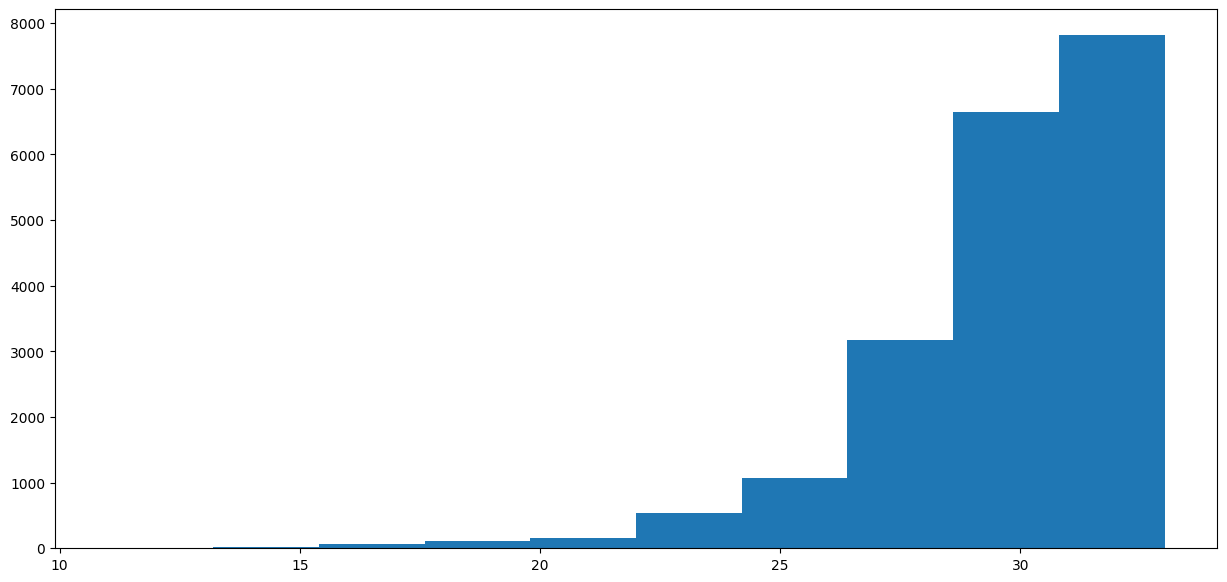

In [85]:
# showing frequency of number of interrupts per ms
fig, ax = plt.subplots(figsize =(15, 7))
n_per_bin, bins, _ = ax.hist(n_itrs)
print('n_per_bin: ', n_per_bin)
plt.show()